<a href="https://colab.research.google.com/github/nanwhoo/vpython/blob/main/%EB%B3%84%EC%9D%98_%ED%9D%A1%EC%88%98%EC%8A%A4%ED%8E%99%ED%8A%B8%EB%9F%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# SDSS SkyServer SQL Search API URL
url = "http://skyserver.sdss.org/dr16/SkyServerWS/SearchTools/SqlSearch"

# SQL 쿼리 작성 (별의 스펙트럼 데이터 쿼리)
query = """
SELECT TOP 10
    specObjID, plate, mjd, fiberID, ra, dec, z, class
FROM SpecObj
WHERE class = 'STAR'
"""

# 요청 파라미터 설정
params = {
    "cmd": query,
    "format": "csv"  # CSV 형식으로 결과를 반환
}

# API 요청 보내기
response = requests.get(url, params=params)

# 응답 확인 및 데이터 저장
if response.status_code == 200:
    file_name = "sdss_star_spectra.csv"
    with open(file_name, "w") as file:
        file.write(response.text)
    print(f"SDSS 데이터 다운로드 성공! 파일명: {file_name}")
else:
    print(f"데이터 다운로드 실패. 상태 코드: {response.status_code}")
    print(f"응답 내용: {response.text}")


SDSS 데이터 다운로드 성공! 파일명: sdss_star_spectra.csv


In [2]:
# 스펙트럼 데이터 가져오기 함수
def fetch_spectrum(plate, mjd, fiber_id):
    spectrum_url = f"http://dr16.sdss.org/spectrumDetail?plateid={plate}&mjd={mjd}&fiber={fiber_id}"
    response = requests.get(spectrum_url)

    if response.status_code == 200:
        file_name = f"spectrum_plate{plate}_mjd{mjd}_fiber{fiber_id}.fits"
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"스펙트럼 데이터 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"스펙트럼 데이터 다운로드 실패. 상태 코드: {response.status_code}")
        return None

# 데이터 시각화 함수
def plot_spectrum(fits_file):
    from astropy.io import fits

    # FITS 파일 열기
    hdul = fits.open(fits_file)
    hdul.info()

    # 데이터 읽기 (가정: 첫 번째 HDU에 스펙트럼 정보 포함)
    data = hdul[1].data
    wavelength = 10 ** data['loglam']  # 로그 파장을 실제 파장으로 변환
    flux = data['flux']

    # 원본 데이터 플롯
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, color='blue', label='Original Spectrum')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Stellar Absorption Spectrum')
    plt.grid(True)
    plt.legend()
    plt.show()

    hdul.close()

# 예제: plate, mjd, fiberID 값으로 스펙트럼 가져오기
plate, mjd, fiber_id = 3586, 55181, 172
fits_file = fetch_spectrum(plate, mjd, fiber_id)

# 스펙트럼 시각화
if fits_file:
    plot_spectrum(fits_file)


스펙트럼 데이터 다운로드 실패. 상태 코드: 404


In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import savgol_filter

# Step 1: SDSS SkyServer SQL API를 사용하여 별 목록 가져오기
def fetch_star_list():
    url = "http://skyserver.sdss.org/dr16/SkyServerWS/SearchTools/SqlSearch"

    query = """
    SELECT TOP 10
        specObjID, plate, mjd, fiberID, ra, dec, z, class
    FROM SpecObj
    WHERE class = 'STAR'
    """

    params = {
        "cmd": query,
        "format": "csv"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        file_name = "sdss_star_list.csv"
        with open(file_name, "w") as file:
            file.write(response.text)
        print(f"별 목록 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"별 목록 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"응답 내용: {response.text}")
        return None

# Step 2: 특정 스펙트럼 데이터를 다운로드하는 함수
def fetch_spectrum(plate, mjd, fiber_id):
    spectrum_url = f"http://dr16.sdss.org/spectrumDetail/get/specById?plateid={plate}&mjd={mjd}&fiber={fiber_id}"
    response = requests.get(spectrum_url)

    if response.status_code == 200:
        file_name = f"spectrum_plate{plate}_mjd{mjd}_fiber{fiber_id}.fits"
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"스펙트럼 데이터 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"스펙트럼 데이터 다운로드 실패. 상태 코드: {response.status_code}")
        return None

# Step 3: 다운로드한 스펙트럼 데이터를 시각화하는 함수
def plot_spectrum(fits_file):
    # FITS 파일 열기
    hdul = fits.open(fits_file)
    hdul.info()

    # 데이터 읽기 (가정: 첫 번째 HDU에 스펙트럼 정보 포함)
    data = hdul[1].data
    wavelength = 10 ** data['loglam']  # 로그 파장을 실제 파장으로 변환
    flux = data['flux']

    # 스무딩 적용
    smoothed_flux = savgol_filter(flux, window_length=51, polyorder=3)

    # 원본 데이터와 스무딩 데이터 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, color='gray', alpha=0.5, label='Original Spectrum')
    plt.plot(wavelength, smoothed_flux, color='blue', label='Smoothed Spectrum')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Stellar Absorption Spectrum')
    plt.grid(True)
    plt.legend()
    plt.show()

    hdul.close()

# Step 4: 전체 실행 흐름
if __name__ == "__main__":
    # 1. 별 목록 가져오기
    star_list_file = fetch_star_list()

    if star_list_file:
        # 별 목록 읽기
        stars = pd.read_csv(star_list_file)
        print(stars.head())

        # 2. 첫 번째 별의 plate, mjd, fiberID 가져오기
        first_star = stars.iloc[0]
        plate = first_star['plate']
        mjd = first_star['mjd']
        fiber_id = first_star['fiberID']

        # 3. 스펙트럼 데이터 다운로드
        fits_file = fetch_spectrum(plate, mjd, fiber_id)

        # 4. 스펙트럼 데이터 시각화
        if fits_file:
            plot_spectrum(fits_file)


별 목록 다운로드 성공! 파일명: sdss_star_list.csv
                                                                          #Table1
specObjID           plate mjd   fiberID ra        dec       z               class
3154868093696632832 2802  54326 351     270.94352 78.583632 -0.0001514952    STAR
3154870567597795328 2802  54326 360     271.23343 78.483078 -6.223064E-05    STAR
3154870017841981440 2802  54326 358     271.76997 78.666606 -8.696781E-05    STAR
3154868918330353664 2802  54326 354     271.85143 78.496456 -0.0003906398    STAR


KeyError: 'plate'

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import savgol_filter

# Step 1: SDSS SkyServer SQL API를 사용하여 별 목록 가져오기
def fetch_star_list():
    url = "http://skyserver.sdss.org/dr16/SkyServerWS/SearchTools/SqlSearch"

    query = """
    SELECT TOP 10
        specObjID, plate, mjd, fiberID, ra, dec, z, class
    FROM SpecObj
    WHERE class = 'STAR'
    """

    params = {
        "cmd": query,
        "format": "csv"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        file_name = "sdss_star_list.csv"
        with open(file_name, "w") as file:
            file.write(response.text)
        print(f"별 목록 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"별 목록 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"응답 내용: {response.text}")
        return None

# Step 2: 특정 스펙트럼 데이터를 다운로드하는 함수
def fetch_spectrum(plate, mjd, fiber_id):
    spectrum_url = f"http://dr16.sdss.org/spectrumDetail/get/specById?plateid={plate}&mjd={mjd}&fiber={fiber_id}"
    response = requests.get(spectrum_url)

    if response.status_code == 200:
        file_name = f"spectrum_plate{plate}_mjd{mjd}_fiber{fiber_id}.fits"
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"스펙트럼 데이터 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"스펙트럼 데이터 다운로드 실패. 상태 코드: {response.status_code}")
        return None

# Step 3: 다운로드한 스펙트럼 데이터를 시각화하는 함수
def plot_spectrum(fits_file):
    # FITS 파일 열기
    hdul = fits.open(fits_file)
    hdul.info()

    # 데이터 읽기 (가정: 첫 번째 HDU에 스펙트럼 정보 포함)
    data = hdul[1].data
    wavelength = 10 ** data['loglam']  # 로그 파장을 실제 파장으로 변환
    flux = data['flux']

    # 스무딩 적용
    smoothed_flux = savgol_filter(flux, window_length=51, polyorder=3)

    # 원본 데이터와 스무딩 데이터 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, color='gray', alpha=0.5, label='Original Spectrum')
    plt.plot(wavelength, smoothed_flux, color='blue', label='Smoothed Spectrum')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Stellar Absorption Spectrum')
    plt.grid(True)
    plt.legend()
    plt.show()

    hdul.close()

# Step 4: 전체 실행 흐름
if __name__ == "__main__":
    # 1. 별 목록 가져오기
    star_list_file = fetch_star_list()

    if star_list_file:
        # 별 목록 읽기
        stars = pd.read_csv(star_list_file)
        print(stars.head())

        # 2. 첫 번째 별의 plate, mjd, fiberID 가져오기
        first_star = stars.iloc[0]
        plate = first_star['plate']
        mjd = first_star['mjd']
        fiber_id = first_star['fiberID']

        # 3. 스펙트럼 데이터 다운로드
        fits_file = fetch_spectrum(plate, mjd, fiber_id)

        # 4. 스펙트럼 데이터 시각화
        if fits_file:
            plot_spectrum(fits_file)


별 목록 다운로드 성공! 파일명: sdss_star_list.csv
                                                                          #Table1
specObjID           plate mjd   fiberID ra        dec       z               class
3154868093696632832 2802  54326 351     270.94352 78.583632 -0.0001514952    STAR
3154870567597795328 2802  54326 360     271.23343 78.483078 -6.223064E-05    STAR
3154870017841981440 2802  54326 358     271.76997 78.666606 -8.696781E-05    STAR
3154868918330353664 2802  54326 354     271.85143 78.496456 -0.0003906398    STAR


KeyError: 'plate'

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import savgol_filter

# Step 1: SDSS SkyServer SQL API를 사용하여 별 목록 가져오기
def fetch_star_list():
    url = "http://skyserver.sdss.org/dr16/SkyServerWS/SearchTools/SqlSearch"

    query = """
    SELECT TOP 10
        specObjID, plate, mjd, fiberID, ra, dec, z, class
    FROM SpecObj
    WHERE class = 'STAR'
    """

    params = {
        "cmd": query,
        "format": "csv"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        file_name = "sdss_star_list.csv"
        with open(file_name, "w") as file:
            file.write(response.text)
        print(f"별 목록 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"별 목록 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"응답 내용: {response.text}")
        return None

# Step 2: 특정 스펙트럼 데이터를 다운로드하는 함수
def fetch_spectrum(plate, mjd, fiber_id):
    spectrum_url = f"http://dr16.sdss.org/spectrumDetail/get/specById?plateid={plate}&mjd={mjd}&fiber={fiber_id}"
    response = requests.get(spectrum_url)

    if response.status_code == 200:
        file_name = f"spectrum_plate{plate}_mjd{mjd}_fiber{fiber_id}.fits"
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"스펙트럼 데이터 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"스펙트럼 데이터 다운로드 실패. 상태 코드: {response.status_code}")
        return None

# Step 3: 다운로드한 스펙트럼 데이터를 시각화하는 함수
def plot_spectrum(fits_file):
    # FITS 파일 열기
    hdul = fits.open(fits_file)
    hdul.info()

    # 데이터 읽기 (가정: 첫 번째 HDU에 스펙트럼 정보 포함)
    data = hdul[1].data
    wavelength = 10 ** data['loglam']  # 로그 파장을 실제 파장으로 변환
    flux = data['flux']

    # 스무딩 적용
    smoothed_flux = savgol_filter(flux, window_length=51, polyorder=3)

    # 원본 데이터와 스무딩 데이터 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, color='gray', alpha=0.5, label='Original Spectrum')
    plt.plot(wavelength, smoothed_flux, color='blue', label='Smoothed Spectrum')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Stellar Absorption Spectrum')
    plt.grid(True)
    plt.legend()
    plt.show()

    hdul.close()

# Step 4: 전체 실행 흐름
if __name__ == "__main__":
    # 1. 별 목록 가져오기
    star_list_file = fetch_star_list()

    if star_list_file:
        # 별 목록 읽기
        stars = pd.read_csv(star_list_file)

        # 열 이름 확인 및 정리
        stars.columns = stars.columns.str.strip()
        print("열 이름:", stars.columns)

        # 첫 번째 별 데이터 추출
        plate = stars['plate'].iloc[0]
        mjd = stars['mjd'].iloc[0]
        fiber_id = stars['fiberID'].iloc[0]

        print(f"Plate: {plate}, MJD: {mjd}, FiberID: {fiber_id}")

        # 2. 스펙트럼 데이터 다운로드
        fits_file = fetch_spectrum(plate, mjd, fiber_id)

        # 3. 스펙트럼 데이터 시각화
        if fits_file:
            plot_spectrum(fits_file)


별 목록 다운로드 성공! 파일명: sdss_star_list.csv
열 이름: Index(['#Table1'], dtype='object')


KeyError: 'plate'

In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import savgol_filter

# Step 1: SDSS SkyServer SQL API를 사용하여 별 목록 가져오기
def fetch_star_list():
    url = "http://skyserver.sdss.org/dr16/SkyServerWS/SearchTools/SqlSearch"

    query = """
    SELECT TOP 10
        specObjID, plate, mjd, fiberID, ra, dec, z, class
    FROM SpecObj
    WHERE class = 'STAR'
    """

    params = {
        "cmd": query,
        "format": "csv"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        file_name = "sdss_star_list.csv"
        with open(file_name, "w") as file:
            file.write(response.text)
        print(f"별 목록 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"별 목록 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"응답 내용: {response.text}")
        return None

# Step 2: 특정 스펙트럼 데이터를 다운로드하는 함수
def fetch_spectrum(plate, mjd, fiber_id):
    spectrum_url = f"http://dr16.sdss.org/spectrumDetail/get/specById?plateid={plate}&mjd={mjd}&fiber={fiber_id}"
    response = requests.get(spectrum_url)

    if response.status_code == 200:
        file_name = f"spectrum_plate{plate}_mjd{mjd}_fiber{fiber_id}.fits"
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"스펙트럼 데이터 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"스펙트럼 데이터 다운로드 실패. 상태 코드: {response.status_code}")
        return None

# Step 3: 다운로드한 스펙트럼 데이터를 시각화하는 함수
def plot_spectrum(fits_file):
    # FITS 파일 열기
    hdul = fits.open(fits_file)
    hdul.info()

    # 데이터 읽기 (가정: 첫 번째 HDU에 스펙트럼 정보 포함)
    data = hdul[1].data
    wavelength = 10 ** data['loglam']  # 로그 파장을 실제 파장으로 변환
    flux = data['flux']

    # 스무딩 적용
    smoothed_flux = savgol_filter(flux, window_length=51, polyorder=3)

    # 원본 데이터와 스무딩 데이터 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, color='gray', alpha=0.5, label='Original Spectrum')
    plt.plot(wavelength, smoothed_flux, color='blue', label='Smoothed Spectrum')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Stellar Absorption Spectrum')
    plt.grid(True)
    plt.legend()
    plt.show()

    hdul.close()

# Step 4: 전체 실행 흐름
if __name__ == "__main__":
    # 1. 별 목록 가져오기
    star_list_file = fetch_star_list()

    if star_list_file:
        # 별 목록 읽기
        stars = pd.read_csv(star_list_file, comment='#')  # 주석 제거 후 읽기

        # 열 이름 확인 및 정리
        if len(stars.columns) == 1:
            stars = stars["#Table1"].str.split(',', expand=True)
            stars.columns = ["specObjID", "plate", "mjd", "fiberID", "ra", "dec", "z", "class"]

        print("열 이름:", stars.columns)

        # 첫 번째 별 데이터 추출
        plate = int(stars['plate'].iloc[0])
        mjd = int(stars['mjd'].iloc[0])
        fiber_id = int(stars['fiberID'].iloc[0])

        print(f"Plate: {plate}, MJD: {mjd}, FiberID: {fiber_id}")

        # 2. 스펙트럼 데이터 다운로드
        fits_file = fetch_spectrum(plate, mjd, fiber_id)

        # 3. 스펙트럼 데이터 시각화
        if fits_file:
            plot_spectrum(fits_file)


별 목록 다운로드 성공! 파일명: sdss_star_list.csv
열 이름: Index(['specObjID', 'plate', 'mjd', 'fiberID', 'ra', 'dec', 'z', 'class'], dtype='object')
Plate: 2802, MJD: 54326, FiberID: 351
스펙트럼 데이터 다운로드 실패. 상태 코드: 404


별 목록 다운로드 성공! 파일명: sdss_star_list.csv
열 이름: Index(['specObjID', 'plate', 'mjd', 'fiberID', 'ra', 'dec', 'z', 'class'], dtype='object')
Plate: 2802, MJD: 54326, FiberID: 351
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber351.fits
Filename: spectrum_plate2802_mjd54326_fiber351.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3834R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1

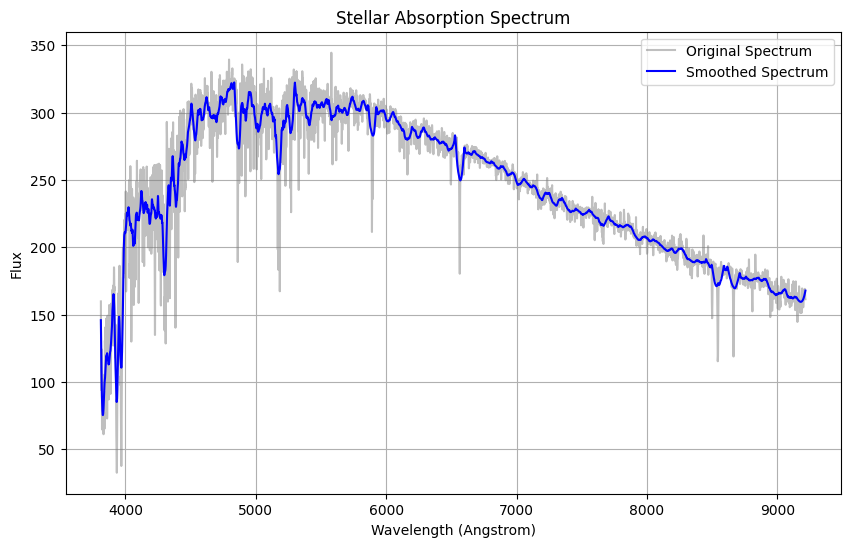

In [7]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import savgol_filter

# Step 1: SDSS SkyServer SQL API를 사용하여 별 목록 가져오기
def fetch_star_list():
    url = "http://skyserver.sdss.org/dr16/SkyServerWS/SearchTools/SqlSearch"

    query = """
    SELECT TOP 10
        specObjID, plate, mjd, fiberID, ra, dec, z, class
    FROM SpecObj
    WHERE class = 'STAR'
    """

    params = {
        "cmd": query,
        "format": "csv"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        file_name = "sdss_star_list.csv"
        with open(file_name, "w") as file:
            file.write(response.text)
        print(f"별 목록 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"별 목록 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"응답 내용: {response.text}")
        return None

# Step 2: 특정 스펙트럼 데이터를 다운로드하는 함수
def fetch_spectrum(plate, mjd, fiber_id):
    spectrum_url = f"https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/{plate}/spec-{plate}-{mjd}-{fiber_id:04d}.fits"
    response = requests.get(spectrum_url)

    if response.status_code == 200:
        file_name = f"spectrum_plate{plate}_mjd{mjd}_fiber{fiber_id}.fits"
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"스펙트럼 데이터 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"스펙트럼 데이터 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"URL: {spectrum_url}")
        return None

# Step 3: 다운로드한 스펙트럼 데이터를 시각화하는 함수
def plot_spectrum(fits_file):
    # FITS 파일 열기
    hdul = fits.open(fits_file)
    hdul.info()

    # 데이터 읽기 (가정: 첫 번째 HDU에 스펙트럼 정보 포함)
    data = hdul[1].data
    wavelength = 10 ** data['loglam']  # 로그 파장을 실제 파장으로 변환
    flux = data['flux']

    # 스무딩 적용
    smoothed_flux = savgol_filter(flux, window_length=51, polyorder=3)

    # 원본 데이터와 스무딩 데이터 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, color='gray', alpha=0.5, label='Original Spectrum')
    plt.plot(wavelength, smoothed_flux, color='blue', label='Smoothed Spectrum')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Stellar Absorption Spectrum')
    plt.grid(True)
    plt.legend()
    plt.show()

    hdul.close()

# Step 4: 전체 실행 흐름
if __name__ == "__main__":
    # 1. 별 목록 가져오기
    star_list_file = fetch_star_list()

    if star_list_file:
        # 별 목록 읽기
        stars = pd.read_csv(star_list_file, comment='#')  # 주석 제거 후 읽기

        # 열 이름 확인 및 정리
        if len(stars.columns) == 1:
            stars = stars["#Table1"].str.split(',', expand=True)
            stars.columns = ["specObjID", "plate", "mjd", "fiberID", "ra", "dec", "z", "class"]

        print("열 이름:", stars.columns)

        # 첫 번째 별 데이터 추출
        plate = int(stars['plate'].iloc[0])
        mjd = int(stars['mjd'].iloc[0])
        fiber_id = int(stars['fiberID'].iloc[0])

        print(f"Plate: {plate}, MJD: {mjd}, FiberID: {fiber_id}")

        # 2. 스펙트럼 데이터 다운로드
        fits_file = fetch_spectrum(plate, mjd, fiber_id)

        # 3. 스펙트럼 데이터 시각화
        if fits_file:
            plot_spectrum(fits_file)


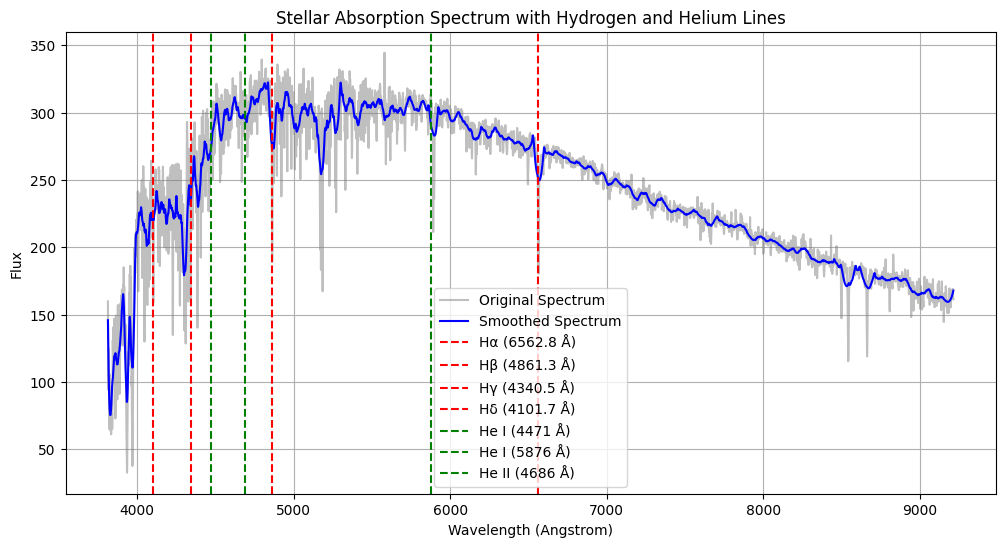

In [8]:
def plot_spectrum_with_lines(fits_file):
    # FITS 파일 열기
    hdul = fits.open(fits_file)
    data = hdul[1].data
    wavelength = 10 ** data['loglam']  # 로그 파장을 실제 파장으로 변환
    flux = data['flux']

    # 스무딩 적용
    smoothed_flux = savgol_filter(flux, window_length=51, polyorder=3)

    # 수소 발머 시리즈와 헬륨 흡수선 파장 (Angstrom 단위)
    hydrogen_lines = {
        "Hα (6562.8 Å)": 6562.8,
        "Hβ (4861.3 Å)": 4861.3,
        "Hγ (4340.5 Å)": 4340.5,
        "Hδ (4101.7 Å)": 4101.7,
    }
    helium_lines = {
        "He I (4471 Å)": 4471,
        "He I (5876 Å)": 5876,
        "He II (4686 Å)": 4686,
    }

    # 스펙트럼 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(wavelength, flux, color='gray', alpha=0.5, label='Original Spectrum')
    plt.plot(wavelength, smoothed_flux, color='blue', label='Smoothed Spectrum')

    # 수소 흡수선 표시
    for label, line in hydrogen_lines.items():
        plt.axvline(x=line, color='red', linestyle='--', label=label)

    # 헬륨 흡수선 표시
    for label, line in helium_lines.items():
        plt.axvline(x=line, color='green', linestyle='--', label=label)

    # 플롯 설정
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title('Stellar Absorption Spectrum with Hydrogen and Helium Lines')
    plt.legend()
    plt.grid(True)
    plt.show()

    hdul.close()

# 실행 흐름에 추가
if fits_file:
    plot_spectrum_with_lines(fits_file)


별 목록 다운로드 성공! 파일명: sdss_star_list.csv
열 이름: Index(['specObjID', 'plate', 'mjd', 'fiberID', 'ra', 'dec', 'z', 'class'], dtype='object')
Processing Star 1: Plate 2802, MJD 54326, FiberID 351
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber351.fits
Filename: spectrum_plate2802_mjd54326_fiber351.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3834R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3 

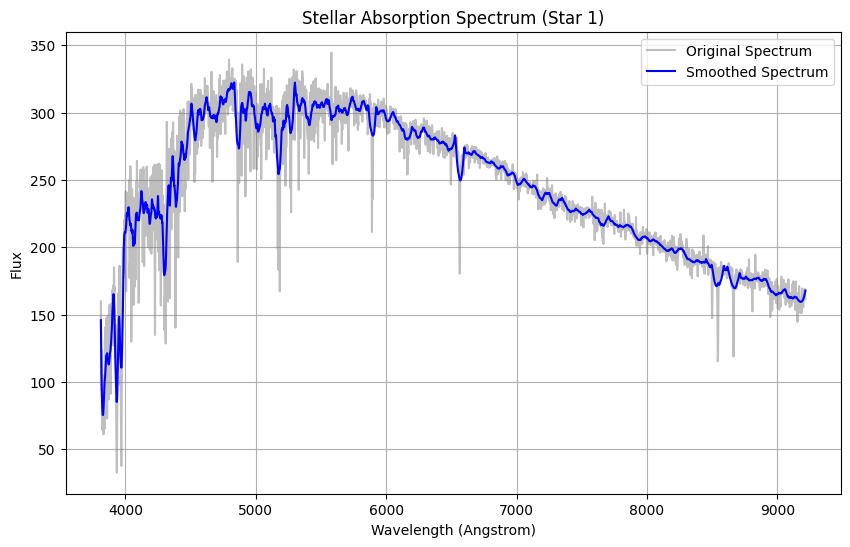

Processing Star 2: Plate 2802, MJD 54326, FiberID 360
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber360.fits
Filename: spectrum_plate2802_mjd54326_fiber360.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3835R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


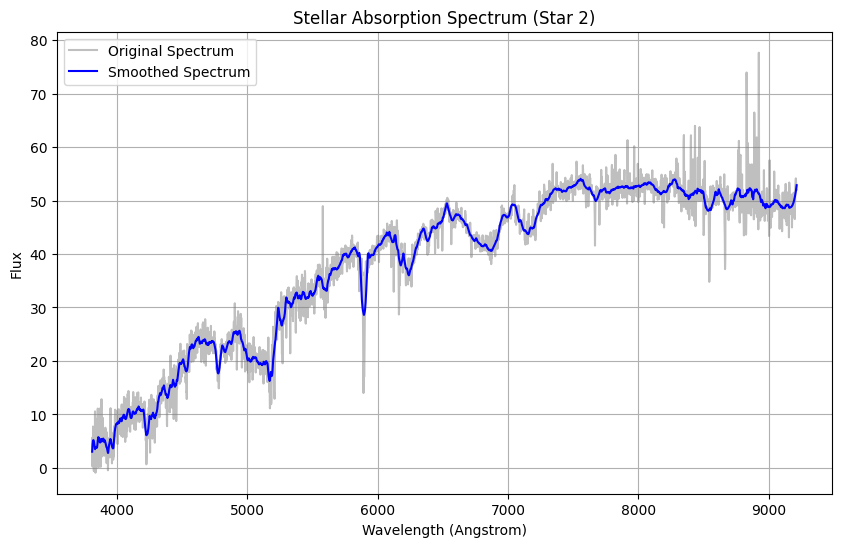

Processing Star 3: Plate 2802, MJD 54326, FiberID 358
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber358.fits
Filename: spectrum_plate2802_mjd54326_fiber358.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3836R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


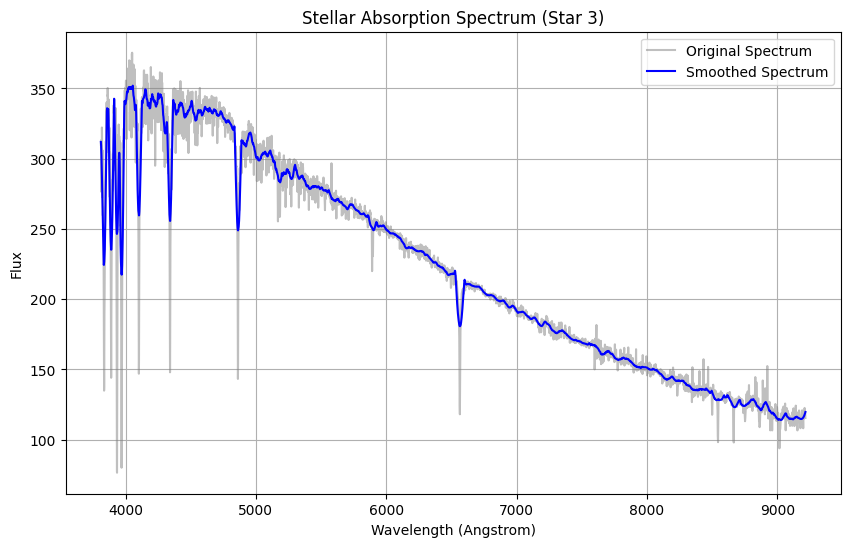

Processing Star 4: Plate 2802, MJD 54326, FiberID 354
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber354.fits
Filename: spectrum_plate2802_mjd54326_fiber354.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3835R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


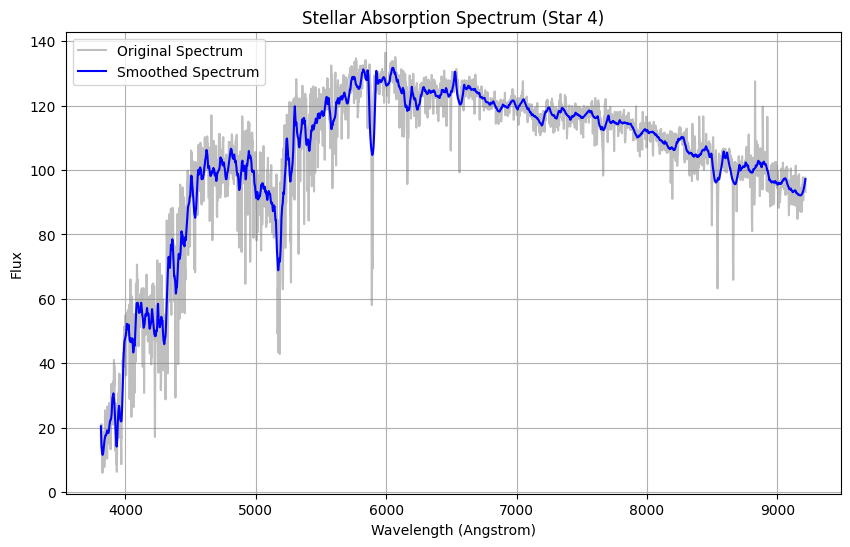

Processing Star 5: Plate 2802, MJD 54326, FiberID 346
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber346.fits
Filename: spectrum_plate2802_mjd54326_fiber346.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3832R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


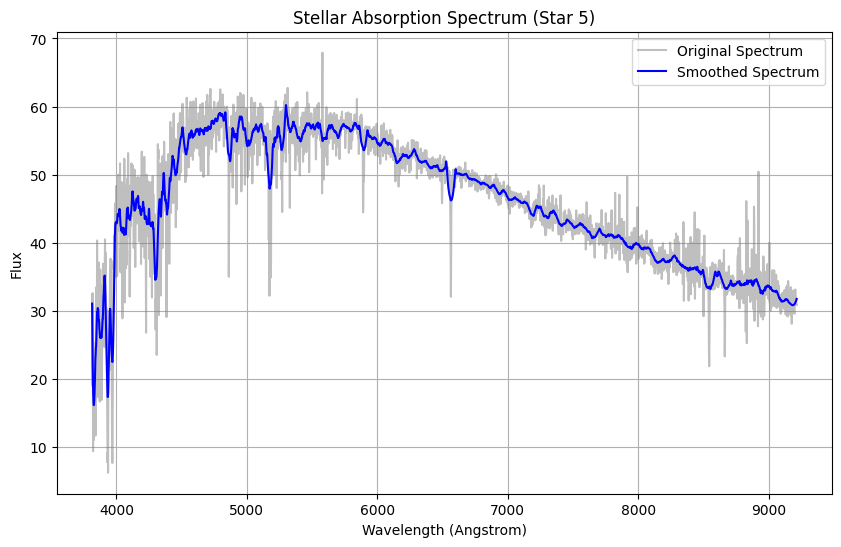

Processing Star 6: Plate 2802, MJD 54326, FiberID 355
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber355.fits
Filename: spectrum_plate2802_mjd54326_fiber355.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3835R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


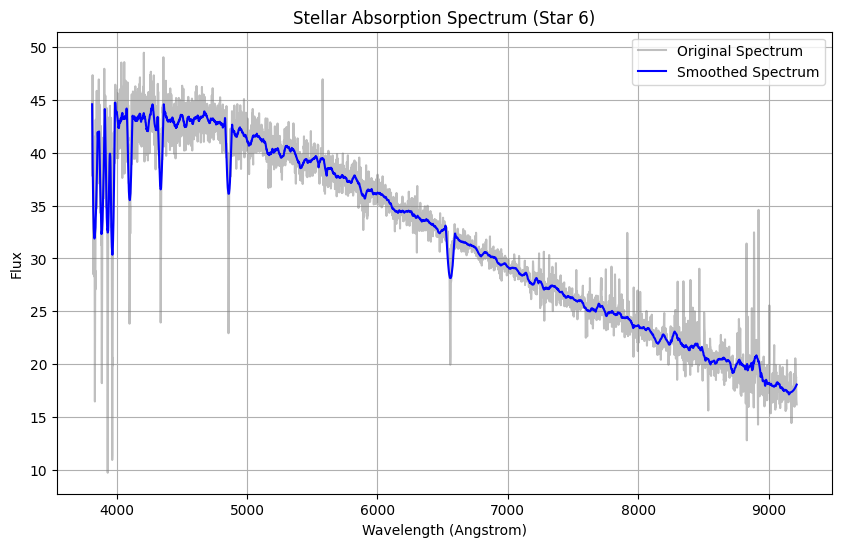

Processing Star 7: Plate 2802, MJD 54326, FiberID 395
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber395.fits
Filename: spectrum_plate2802_mjd54326_fiber395.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3843R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


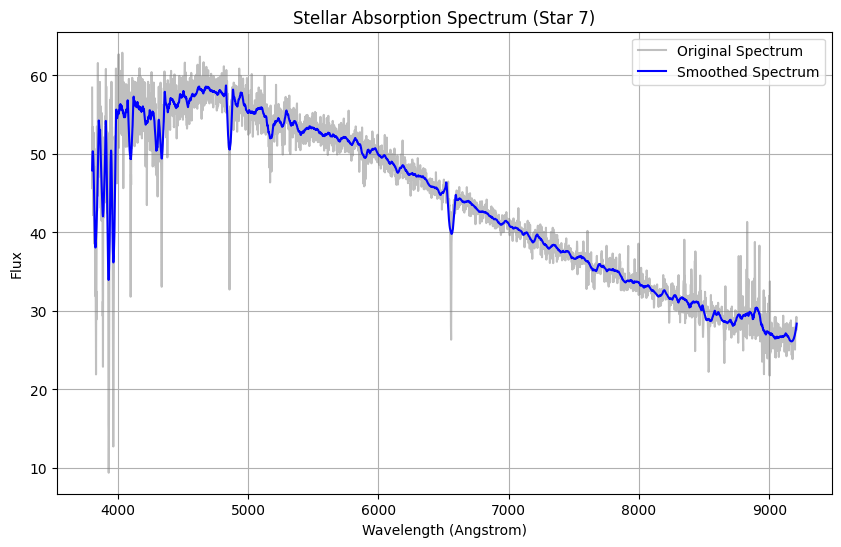

Processing Star 8: Plate 2802, MJD 54326, FiberID 399
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber399.fits
Filename: spectrum_plate2802_mjd54326_fiber399.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3843R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


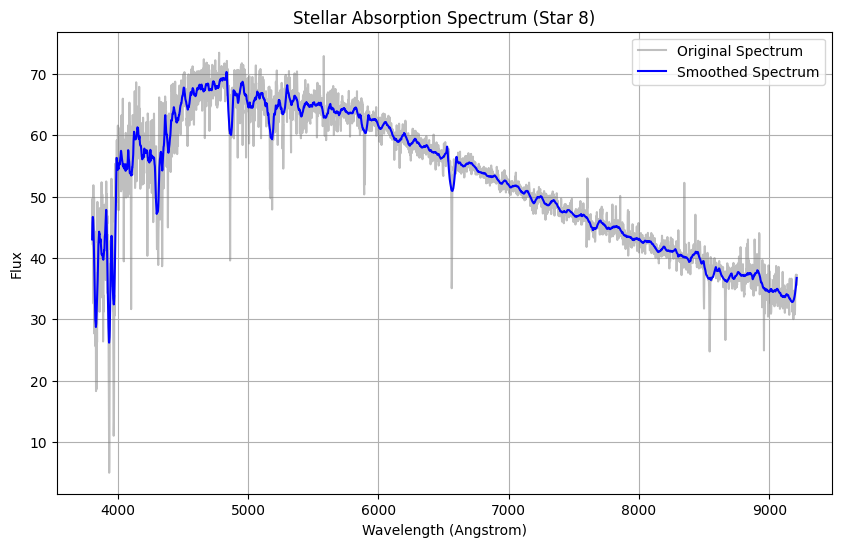

Processing Star 9: Plate 2802, MJD 54326, FiberID 392
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber392.fits
Filename: spectrum_plate2802_mjd54326_fiber392.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3842R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


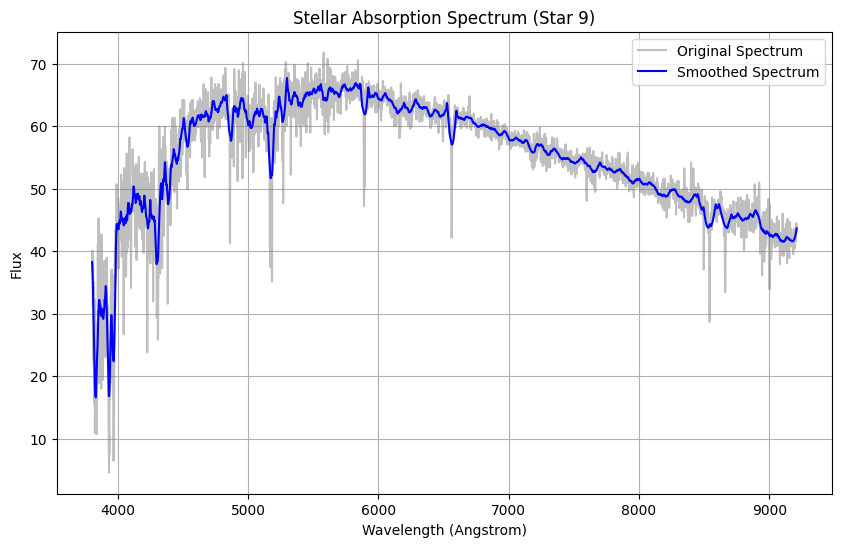

Processing Star 10: Plate 2802, MJD 54326, FiberID 400
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber400.fits
Filename: spectrum_plate2802_mjd54326_fiber400.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3843R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


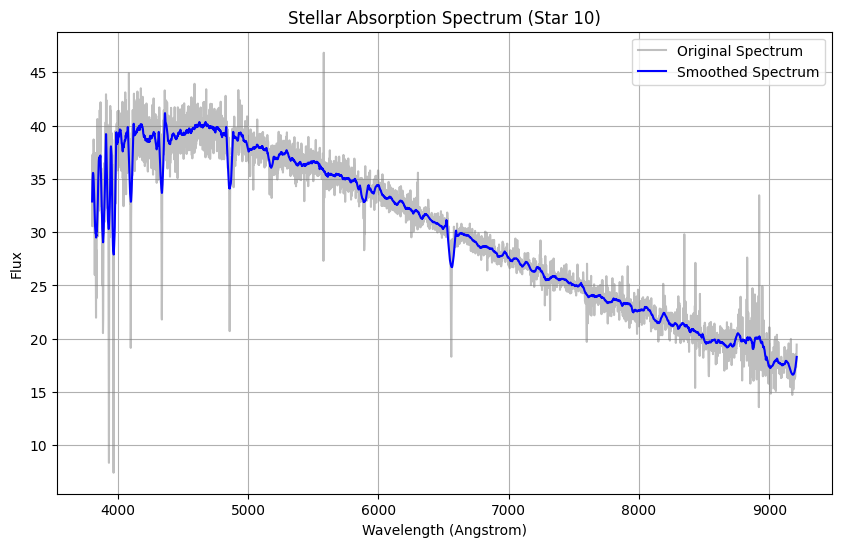

In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import savgol_filter

# Step 1: SDSS SkyServer SQL API를 사용하여 별 목록 가져오기
def fetch_star_list():
    url = "http://skyserver.sdss.org/dr16/SkyServerWS/SearchTools/SqlSearch"

    query = """
    SELECT TOP 10
        specObjID, plate, mjd, fiberID, ra, dec, z, class
    FROM SpecObj
    WHERE class = 'STAR'
    """

    params = {
        "cmd": query,
        "format": "csv"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        file_name = "sdss_star_list.csv"
        with open(file_name, "w") as file:
            file.write(response.text)
        print(f"별 목록 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"별 목록 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"응답 내용: {response.text}")
        return None

# Step 2: 특정 스펙트럼 데이터를 다운로드하는 함수
def fetch_spectrum(plate, mjd, fiber_id):
    spectrum_url = f"https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/{plate}/spec-{plate}-{mjd}-{fiber_id:04d}.fits"
    response = requests.get(spectrum_url)

    if response.status_code == 200:
        file_name = f"spectrum_plate{plate}_mjd{mjd}_fiber{fiber_id}.fits"
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"스펙트럼 데이터 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"스펙트럼 데이터 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"URL: {spectrum_url}")
        return None

# Step 3: 다운로드한 스펙트럼 데이터를 시각화하는 함수
def plot_spectrum(fits_file, title_suffix=""):
    # FITS 파일 열기
    hdul = fits.open(fits_file)
    hdul.info()

    # 데이터 읽기 (가정: 첫 번째 HDU에 스펙트럼 정보 포함)
    data = hdul[1].data
    wavelength = 10 ** data['loglam']  # 로그 파장을 실제 파장으로 변환
    flux = data['flux']

    # 스무딩 적용
    smoothed_flux = savgol_filter(flux, window_length=51, polyorder=3)

    # 원본 데이터와 스무딩 데이터 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, color='gray', alpha=0.5, label='Original Spectrum')
    plt.plot(wavelength, smoothed_flux, color='blue', label='Smoothed Spectrum')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title(f'Stellar Absorption Spectrum {title_suffix}')
    plt.grid(True)
    plt.legend()
    plt.show()

    hdul.close()

# Step 4: 전체 실행 흐름
if __name__ == "__main__":
    # 1. 별 목록 가져오기
    star_list_file = fetch_star_list()

    if star_list_file:
        # 별 목록 읽기
        stars = pd.read_csv(star_list_file, comment='#')  # 주석 제거 후 읽기

        # 열 이름 확인 및 정리
        if len(stars.columns) == 1:
            stars = stars["#Table1"].str.split(',', expand=True)
            stars.columns = ["specObjID", "plate", "mjd", "fiberID", "ra", "dec", "z", "class"]

        print("열 이름:", stars.columns)

        # 여러 별에 대해 반복 처리
        for index, row in stars.iterrows():
            plate = int(row['plate'])
            mjd = int(row['mjd'])
            fiber_id = int(row['fiberID'])

            print(f"Processing Star {index + 1}: Plate {plate}, MJD {mjd}, FiberID {fiber_id}")

            # 스펙트럼 데이터 다운로드
            fits_file = fetch_spectrum(plate, mjd, fiber_id)

            # 스펙트럼 데이터 시각화
            if fits_file:
                plot_spectrum(fits_file, title_suffix=f"(Star {index + 1})")


별 목록 다운로드 성공! 파일명: sdss_star_list.csv
열 이름: Index(['specObjID', 'plate', 'mjd', 'fiberID', 'ra', 'dec', 'z', 'class'], dtype='object')
Processing Star 1: Plate 2802, MJD 54326, FiberID 351
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber351.fits
Filename: spectrum_plate2802_mjd54326_fiber351.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3834R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3 

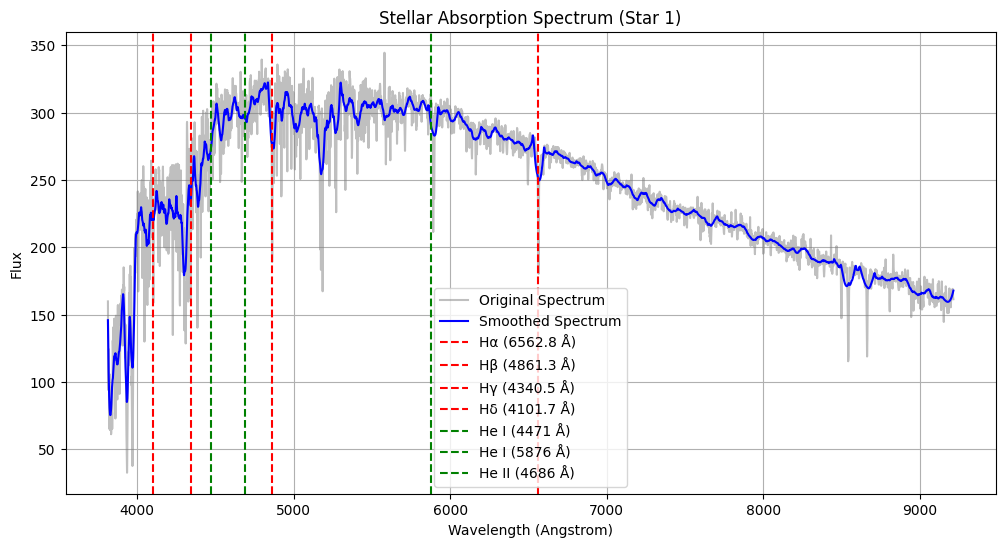

Processing Star 2: Plate 2802, MJD 54326, FiberID 360
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber360.fits
Filename: spectrum_plate2802_mjd54326_fiber360.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3835R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


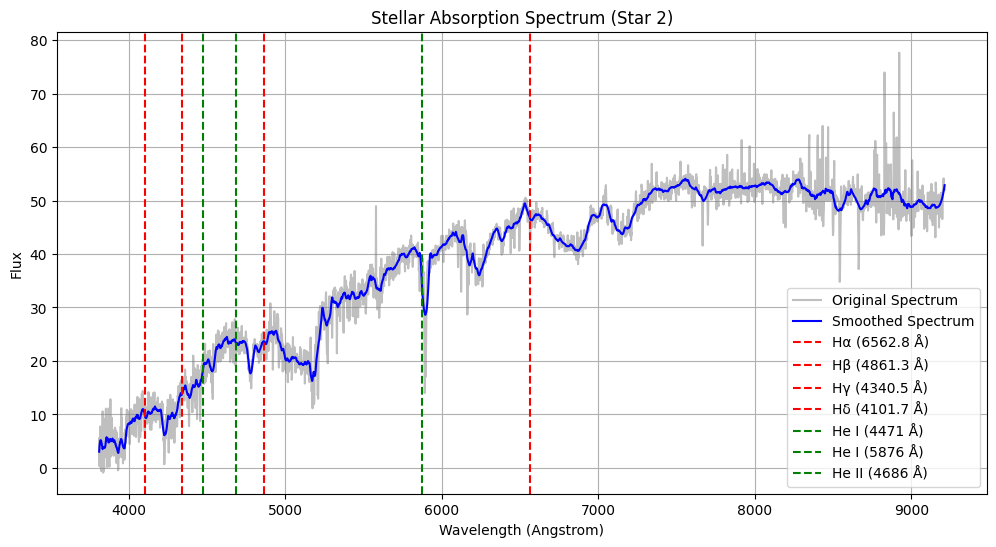

Processing Star 3: Plate 2802, MJD 54326, FiberID 358
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber358.fits
Filename: spectrum_plate2802_mjd54326_fiber358.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3836R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


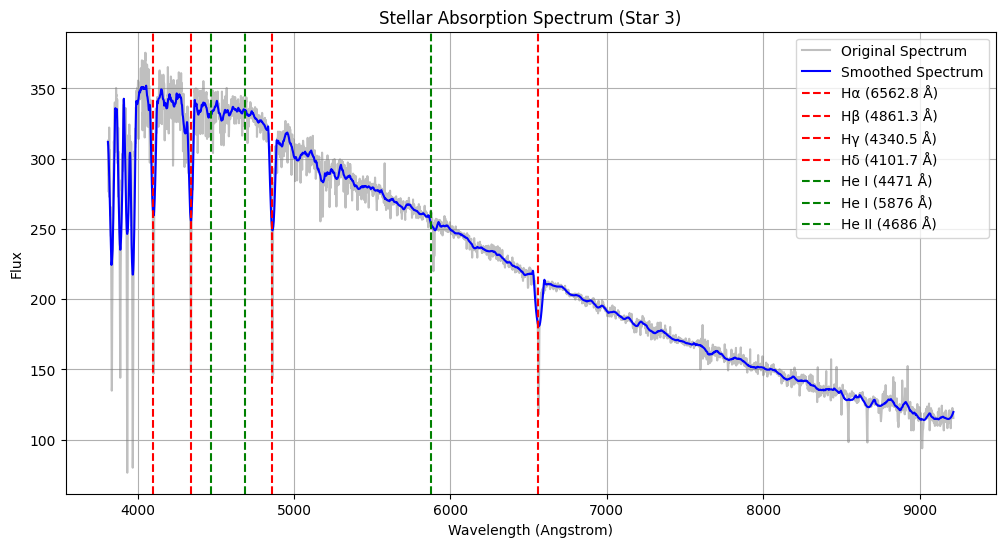

Processing Star 4: Plate 2802, MJD 54326, FiberID 354
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber354.fits
Filename: spectrum_plate2802_mjd54326_fiber354.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3835R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


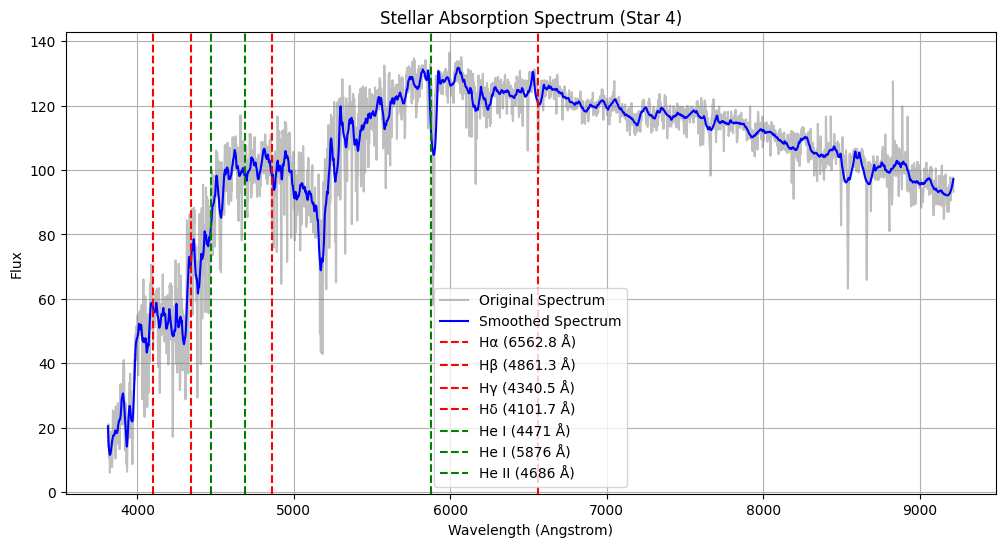

Processing Star 5: Plate 2802, MJD 54326, FiberID 346
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber346.fits
Filename: spectrum_plate2802_mjd54326_fiber346.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3832R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


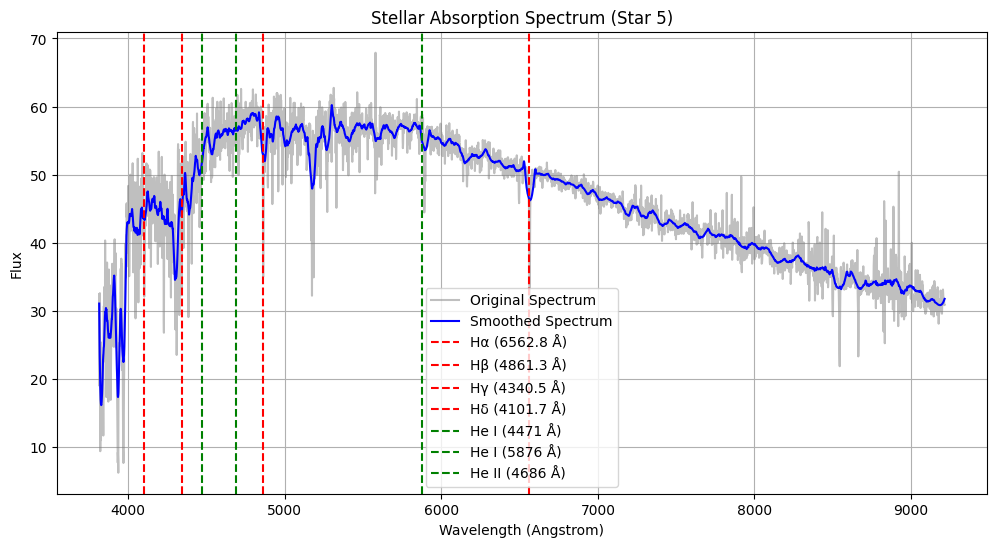

Processing Star 6: Plate 2802, MJD 54326, FiberID 355
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber355.fits
Filename: spectrum_plate2802_mjd54326_fiber355.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3835R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


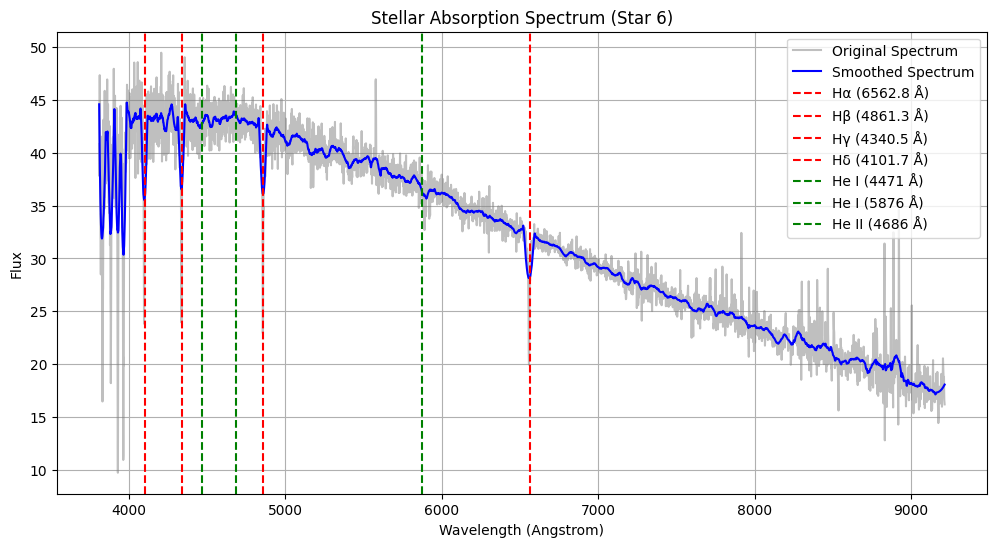

Processing Star 7: Plate 2802, MJD 54326, FiberID 395
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber395.fits
Filename: spectrum_plate2802_mjd54326_fiber395.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3843R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


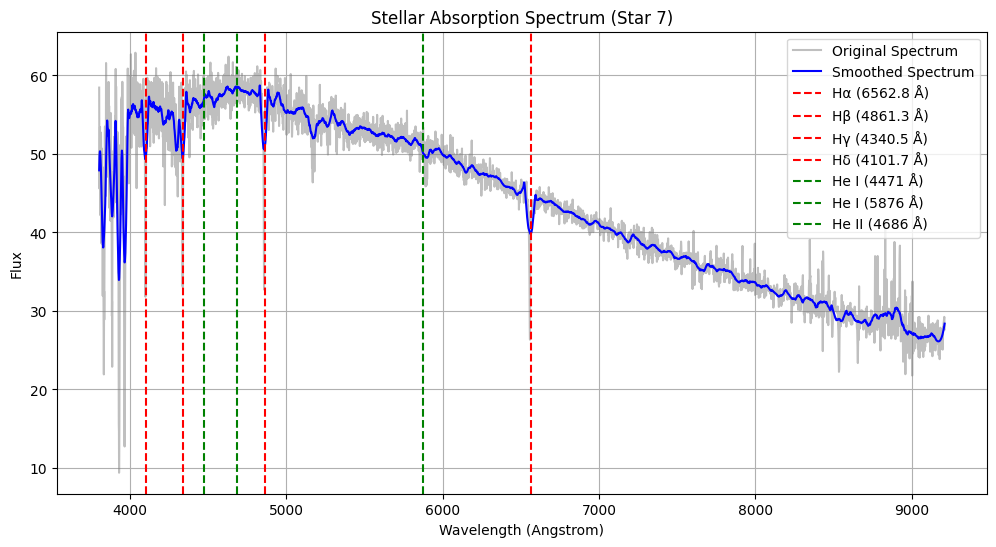

Processing Star 8: Plate 2802, MJD 54326, FiberID 399
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber399.fits
Filename: spectrum_plate2802_mjd54326_fiber399.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3843R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


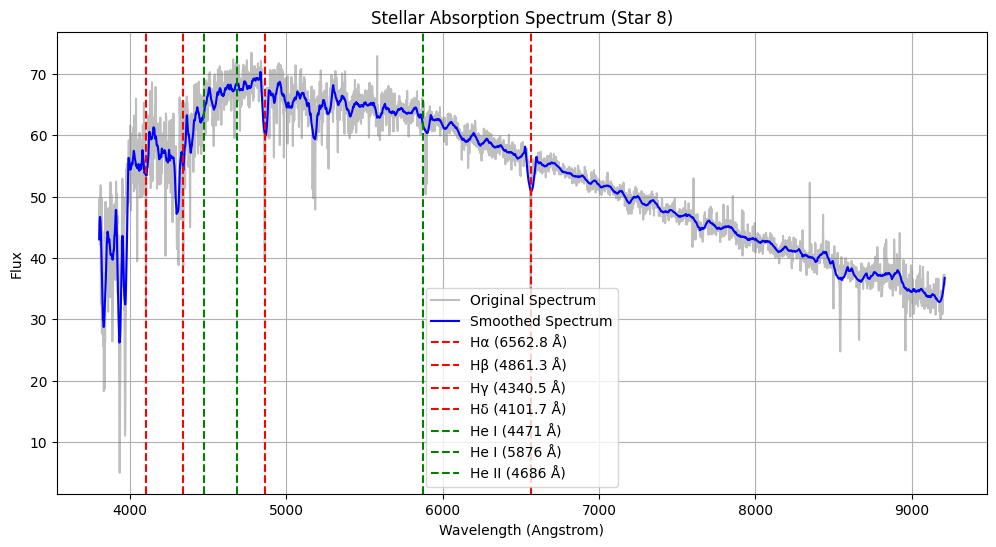

Processing Star 9: Plate 2802, MJD 54326, FiberID 392
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber392.fits
Filename: spectrum_plate2802_mjd54326_fiber392.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3842R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


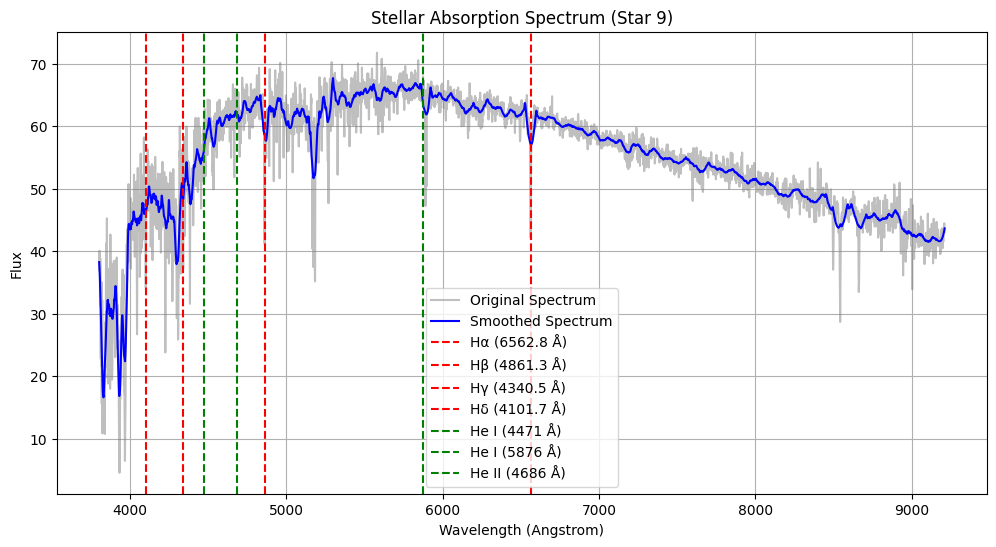

Processing Star 10: Plate 2802, MJD 54326, FiberID 400
스펙트럼 데이터 다운로드 성공! 파일명: spectrum_plate2802_mjd54326_fiber400.fits
Filename: spectrum_plate2802_mjd54326_fiber400.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3843R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


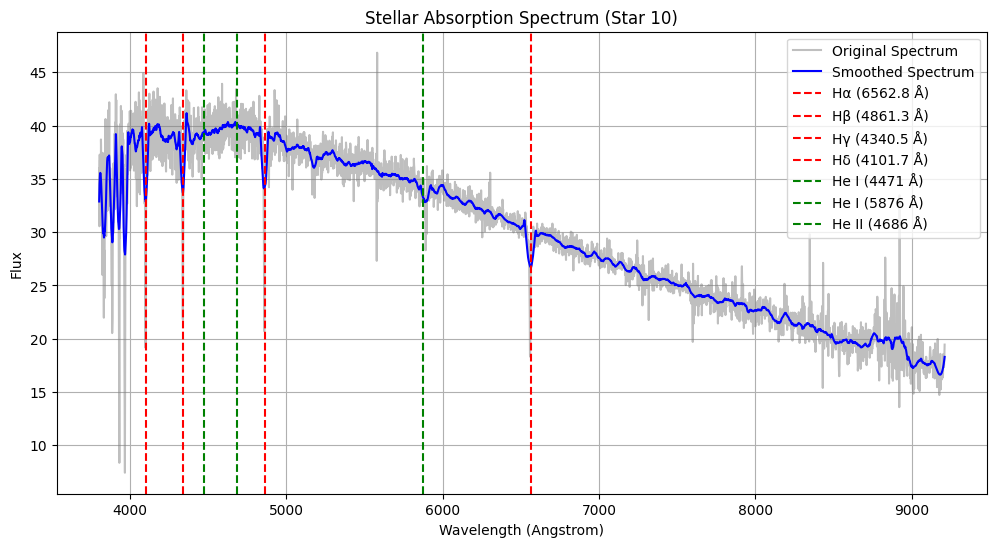

In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import savgol_filter

# Step 1: SDSS SkyServer SQL API를 사용하여 별 목록 가져오기
def fetch_star_list():
    url = "http://skyserver.sdss.org/dr16/SkyServerWS/SearchTools/SqlSearch"

    query = """
    SELECT TOP 10
        specObjID, plate, mjd, fiberID, ra, dec, z, class
    FROM SpecObj
    WHERE class = 'STAR'
    """

    params = {
        "cmd": query,
        "format": "csv"
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        file_name = "sdss_star_list.csv"
        with open(file_name, "w") as file:
            file.write(response.text)
        print(f"별 목록 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"별 목록 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"응답 내용: {response.text}")
        return None

# Step 2: 특정 스펙트럼 데이터를 다운로드하는 함수
def fetch_spectrum(plate, mjd, fiber_id):
    spectrum_url = f"https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/lite/{plate}/spec-{plate}-{mjd}-{fiber_id:04d}.fits"
    response = requests.get(spectrum_url)

    if response.status_code == 200:
        file_name = f"spectrum_plate{plate}_mjd{mjd}_fiber{fiber_id}.fits"
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"스펙트럼 데이터 다운로드 성공! 파일명: {file_name}")
        return file_name
    else:
        print(f"스펙트럼 데이터 다운로드 실패. 상태 코드: {response.status_code}")
        print(f"URL: {spectrum_url}")
        return None

# Step 3: 다운로드한 스펙트럼 데이터를 시각화하는 함수
def plot_spectrum(fits_file, title_suffix=""):
    # FITS 파일 열기
    hdul = fits.open(fits_file)
    hdul.info()

    # 데이터 읽기 (가정: 첫 번째 HDU에 스펙트럼 정보 포함)
    data = hdul[1].data
    wavelength = 10 ** data['loglam']  # 로그 파장을 실제 파장으로 변환
    flux = data['flux']

    # 스무딩 적용
    smoothed_flux = savgol_filter(flux, window_length=51, polyorder=3)

    # 수소와 헬륨 흡수선
    hydrogen_lines = {
        "Hα (6562.8 Å)": 6562.8,
        "Hβ (4861.3 Å)": 4861.3,
        "Hγ (4340.5 Å)": 4340.5,
        "Hδ (4101.7 Å)": 4101.7,
    }
    helium_lines = {
        "He I (4471 Å)": 4471,
        "He I (5876 Å)": 5876,
        "He II (4686 Å)": 4686,
    }

    # 원본 데이터와 스무딩 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(wavelength, flux, color='gray', alpha=0.5, label='Original Spectrum')
    plt.plot(wavelength, smoothed_flux, color='blue', label='Smoothed Spectrum')

    # 수소 흡수선 표시
    for label, line in hydrogen_lines.items():
        plt.axvline(x=line, color='red', linestyle='--', label=label)

    # 헬륨 흡수선 표시
    for label, line in helium_lines.items():
        plt.axvline(x=line, color='green', linestyle='--', label=label)

    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux')
    plt.title(f'Stellar Absorption Spectrum {title_suffix}')
    plt.grid(True)
    plt.legend()
    plt.show()

    hdul.close()

# Step 4: 전체 실행 흐름
if __name__ == "__main__":
    # 1. 별 목록 가져오기
    star_list_file = fetch_star_list()

    if star_list_file:
        # 별 목록 읽기
        stars = pd.read_csv(star_list_file, comment='#')  # 주석 제거 후 읽기

        # 열 이름 확인 및 정리
        if len(stars.columns) == 1:
            stars = stars["#Table1"].str.split(',', expand=True)
            stars.columns = ["specObjID", "plate", "mjd", "fiberID", "ra", "dec", "z", "class"]

        print("열 이름:", stars.columns)

        # 여러 별에 대해 반복 처리
        for index, row in stars.iterrows():
            plate = int(row['plate'])
            mjd = int(row['mjd'])
            fiber_id = int(row['fiberID'])

            print(f"Processing Star {index + 1}: Plate {plate}, MJD {mjd}, FiberID {fiber_id}")

            # 스펙트럼 데이터 다운로드
            fits_file = fetch_spectrum(plate, mjd, fiber_id)

            # 스펙트럼 데이터 시각화
            if fits_file:
                plot_spectrum(fits_file, title_suffix=f"(Star {index + 1})")
